In [1]:
from torch import nn, optim
import torch as t
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from collections import OrderedDict
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
from typing import Tuple, Dict, List, Union, Optional, Any, Callable, Type
import matplotlib.pyplot as plt
from matplotlib.axes._axes import Axes
from functools import partial
import numpy as np
PROJECT_PRIME_SEED = 2137

In [2]:
t.manual_seed(PROJECT_PRIME_SEED)

In [3]:
f_mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [4]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=f_mnist_transform
)
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=f_mnist_transform
)

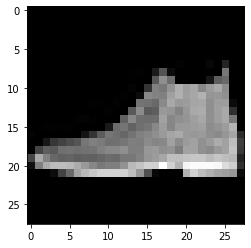

(tensor(1.), tensor(0.))

In [5]:
image: t.Tensor = test_data[0][0]
image = image.permute(1, 2, 0).add(1).mul(0.5)
plt.imshow(image, cmap="gray")
plt.show()
image.max(), image.min()

In [6]:
class Conv2dAutoPad(nn.Conv2d):
	def __init__(self, in_channels: int,
				 out_channels: int,
				 kernel_size: Union[int,Tuple[int, int]], 
			  	 stride:Union[int,Tuple[int, int]] =1,
				 dilation: Union[int,Tuple[int, int]] =1, 
				 groups: int =1,
				 bias: bool =True,
				 device=None,
				 dtype=None) -> None:
	 
		super().__init__(in_channels,
						 out_channels,
						 kernel_size,
						 stride,
						 dilation=dilation,
						 groups=groups,
						 bias=bias,
						 device=device,
						 dtype=dtype)
  
		self.padding = (0,0)
		self.auto_padding = sum(list(map(lambda x: (x//2, max(x//2 - 1 + (x&1), 0)), self.kernel_size[::-1])), ())
  
	def forward(self, X: t.Tensor):
		padded = F.pad(X, self.auto_padding)
		return super().forward(padded)

	def extra_repr(self):
		base = super().extra_repr()
		s = f', auto_padding={self.auto_padding}'
		return base + s

class ConvTranspose2dAutoPad(nn.ConvTranspose2d):
	def __init__(self, in_channels: int,
                 out_channels: int,
                 kernel_size: Union[int,Tuple[int, int]], 
              	 stride:Union[int,Tuple[int, int]] =1,
                 dilation: Union[int,Tuple[int, int]] =1, 
                 groups: int =1,
                 bias: bool =True,
                 device=None,
                 dtype=None) -> None:
     
		super().__init__(in_channels,
                         out_channels,
                         kernel_size,
                         stride,
                         dilation=dilation,
                         groups=groups,
                         bias=bias,
                         device=device,
                         dtype=dtype)
		self.padding = (0,0)
		self.x_padding, self.y_padding = list(map(lambda x: (max(x//2 - 1 + (x&1), 0), x//2), self.kernel_size))
  
	def forward(self, X: t.Tensor, output_size: List[int]):
		x, y = output_size[-2:]
		self.padding = (self.x_padding[x&1], self.y_padding[y&1])
		return super().forward(X, output_size)

	def extra_repr(self):
		base = super().extra_repr()
		s = f', x_padding={self.x_padding}, y_padding={self.y_padding}'
		return base + s

class ConvFractStrided2dAutoPad(nn.Conv2d):
	def __init__(self, in_channels: int,
                 out_channels: int,
                 kernel_size: Union[int,Tuple[int, int]], 
              	 stride:Union[int,Tuple[int, int]] =1,
                 dilation: Union[int,Tuple[int, int]] =1, 
                 groups: int =1,
                 bias: bool =True,
                 device=None,
                 dtype=None) -> None:
     
		super().__init__(in_channels,
                         out_channels,
                         kernel_size,
                         1,
                         dilation=dilation,
                         groups=groups,
                         bias=bias,
                         device=device,
                         dtype=dtype)
		self.padding = (0,0)
		self.decl_stride = stride
		self.auto_padding = sum(list(map(lambda x: (x//2, max(x//2 - 1 + (x&1), 0)), self.kernel_size[::-1])), ())
		self.scaler = nn.Upsample(scale_factor=self.decl_stride)
		self.fitter = nn.Upsample()
  
	def forward(self, X: t.Tensor, output_size: List[int]):
		x, y = output_size[-2:]
		self.fitter.size = (x, y)
		X = self.scaler(X)
		padded = F.pad(X, self.auto_padding)
		return self.fitter(super().forward(padded))

	def extra_repr(self):
		base = super().extra_repr()
		s = f', auto_padding={self.auto_padding}'
		return base + s

class MaxPool2dAutoPad(nn.MaxPool2d):
	def __init__(self, kernel_size:  
				 Union[int,Tuple[int, int]],
				 stride: Union[int,Tuple[int, int]] = None,
			  	 dilation: Union[int,Tuple[int, int]] = 1,
				 return_indices: bool = False) -> None:
			
		super().__init__(kernel_size, 
						 stride,
						 dilation=dilation,
						 return_indices=return_indices,
						 ceil_mode=True)
		self.x_padding, self.y_padding = list(map(lambda x: (max(x//2 - 1, 0), x//2), self.kernel_size))
  
	def forward(self, X: t.Tensor):
		x, y = X.shape[-2:]
		self.padding = (self.x_padding[x&1], self.y_padding[y&1])
		return super().forward(X)

	def extra_repr(self):
		base = super().extra_repr()
		s = f', x_padding={self.x_padding}, y_padding={self.y_padding}'
		return base + s

class MaxUnPool2dAutoPad(nn.MaxUnpool2d):
	def __init__(self, kernel_size:  
                 Union[int,Tuple[int, int]],
                 stride: Union[int,Tuple[int, int]] = None) -> None:
		    
		super().__init__(kernel_size, 
                         stride)
		self.x_padding, self.y_padding = list(map(lambda x: (max(x//2 - 1, 0), x//2), self.kernel_size))
  
	def forward(self, X: t.Tensor, indices: t.Tensor, output_size:List[int]):
		x, y = output_size[-2:]
		self.padding = (self.x_padding[x&1], self.y_padding[y&1])
		return super().forward(X, indices, output_size)

	def extra_repr(self):
		base = super().extra_repr()
		s = f', x_padding={self.x_padding}, y_padding={self.y_padding}'
		return base + s

In [7]:
class Activations:
	_modules: Dict[str, Callable[[],nn.Module]] = {
		'relu': lambda: nn.ReLU(False),
		'prelu-1':lambda: nn.PReLU(),
		'prelu-3':lambda: nn.PReLU(3),
		'prelu-8':lambda: nn.PReLU(8),
		'prelu-16':lambda: nn.PReLU(16),
		'prelu-32':lambda: nn.PReLU(32),
		'prelu-64':lambda: nn.PReLU(64),
		'prelu-128':lambda: nn.PReLU(128),
		'prelu-256':lambda: nn.PReLU(256),
		'prelu-512':lambda: nn.PReLU(512),
		'prelu-1024':lambda: nn.PReLU(1024),
		'leaky-relu':lambda: nn.LeakyReLU(),
		'tanh':lambda: nn.Tanh(),
		'selu':lambda: nn.SELU(False),
		'sigmoid':lambda: nn.Sigmoid(),
		'leaky-relu-01':lambda:nn.LeakyReLU(0.1),
		'leaky-relu-001':lambda:nn.LeakyReLU(),
		'leaky-relu-02':lambda:nn.LeakyReLU(0.2),
		'leaky-relu-005':lambda:nn.LeakyReLU(0.05)
	}
 
	@classmethod
	def get(cls, activation): return Activations._modules.get(activation, lambda: nn.Identity())()

In [8]:
def to_2dim(item: Union[int, Tuple[int, int]]) -> Tuple[int, int]: 
    return (item, item) if isinstance(item, int) else tuple(item)

In [9]:
class ConvDownSampleBlock(nn.Module):
	def __init__(self,kernel_size: Union[int, Tuple[int,int]], in_features:int, out_features:int, 
					activation: str ='relu', stride: Union[int, Tuple[int,int]]=2, 
					groups: int =1, pooling_kernel: Union[int, Tuple[int,int]] =None, 
					device=None, dtype=None):
		super().__init__()
		self.last_indices: t.Tensor =None
		self.last_conv_in_shape: Tuple[int, ...] =None
		self.last_pool_in_shape: Tuple[int, ...] =None
		stride = to_2dim(stride)
		kernel_size = to_2dim(kernel_size)
		self.pooling_applicable = bool(pooling_kernel)
  
		if self.pooling_applicable:
			pooling_kernel = to_2dim(pooling_kernel)
   
		self.conv = Conv2dAutoPad(in_features,
                            	  out_features,
                               	  kernel_size,
                                  stride=stride if not self.pooling_applicable else tuple(np.ones_like(stride).tolist()),
								  bias=False,
						 		  groups=groups,
           						  device=device,
                   				  dtype=dtype)
		self.bn = nn.BatchNorm2d(out_features)
		self.activation_layer = Activations.get(activation)
		self.pooling = MaxPool2dAutoPad(pooling_kernel, stride, return_indices=True) if self.pooling_applicable else nn.Identity()
  
	def forward(self, x:t.Tensor):
		self.last_conv_in_shape = x.shape 
		x = self.conv(x)
		#print("CONV:", x.shape, self.last_conv_in_shape)

		x = self.activation_layer(self.bn(x))
		if self.pooling_applicable:
			old = x
			self.last_pool_in_shape = old.shape
			x, self.last_indices = self.pooling(x)
			#print("POOLING:", old.shape, self.last_indices.shape)
			return x
		return self.pooling(x)

In [10]:
def conv_downsample(kernel_size: Union[int, Tuple[int,int]], in_features:int, out_features:int, 
                    activation: str ='relu', stride: Union[int, Tuple[int,int]]=2, 
                    groups: int =1, pooling_kernel: Union[int, Tuple[int,int]] =None, 
                    device=None, dtype=None):
    return ConvDownSampleBlock(kernel_size, in_features, out_features, activation, stride, groups, pooling_kernel, device, dtype)

In [11]:
class ConvUpSampleBlock(nn.Module):
	def __init__(self, kernel_size: Union[int, Tuple[int,int]], in_features:int, out_features:int, 
				  activation: str ='relu', stride: Union[int, Tuple[int,int]]=2, 
				  groups: int =1, pooling_kernel: Union[int, Tuple[int,int]] =None, use_fract_strided=False,
				  device=None, dtype=None):
		super().__init__()
		stride = to_2dim(stride)
		kernel_size = to_2dim(kernel_size)
		self.pooling_applicable = bool(pooling_kernel) and not use_fract_strided

		if self.pooling_applicable:
			pooling_kernel = to_2dim(pooling_kernel)
   
		self.unpooling = MaxUnPool2dAutoPad(pooling_kernel, stride) if self.pooling_applicable else nn.Identity()
		self.deconv = ConvTranspose2dAutoPad(in_features, 
                                       		 out_features, 
                                          	 kernel_size, 
                                             stride=stride if not self.pooling_applicable else tuple(np.ones_like(stride).tolist()),
							 				 groups=groups,
											 bias=False,
             								 device=device,
                      						 dtype=dtype) if not use_fract_strided else ConvFractStrided2dAutoPad(in_features,
                                                                                                  				  out_features,
                                                                                                        		  kernel_size, 
                                                                                                            	  stride=stride,
                                                                                                               	  groups=groups, 
                                                                                                                  device=device, 
                                                                                                                  dtype=dtype)
		self.bn = nn.BatchNorm2d(out_features)
		self.activation_layer = Activations.get(activation)
  
	def forward(self, x:t.Tensor, expected_shape: Tuple[int, ...], indices:Optional[t.Tensor] = None, expected_pool_shape: Optional[Tuple[int, ...]] = None):
		#if self.pooling_applicable: print("UNPOOLING:", x.shape, indices.shape)
		x = self.unpooling(x, indices, expected_pool_shape) if self.pooling_applicable else self.unpooling(x)
		#print("DECONV:", x.shape, expected_shape)

		x = self.deconv(x, output_size=expected_shape)

		x = self.bn(x)
		return self.activation_layer(x)

In [12]:
def conv_upsample(kernel_size: Union[int, Tuple[int,int]], in_features:int, out_features:int, 
                  activation: str ='relu', stride: Union[int, Tuple[int,int]]=2, 
                  groups: int =1, pooling_kernel: Union[int, Tuple[int,int]] =None, 
                  use_fract_strided=False, device=None, dtype=None):
     
    return ConvUpSampleBlock(kernel_size, in_features, out_features, activation, stride, groups, pooling_kernel, use_fract_strided, device, dtype)

In [13]:
class Generator(nn.Module):
	def __init__(self, 
				 img_shape: Tuple[int, int, int],
				 latent_space: int,
				 kernel_size: int,
				 hidden_features: List[int] =[1024, 512, 256, 128],
				 use_fract_strided_conv: bool =False, 
				 device=None,
				 dtype=None):
		super().__init__()
		assert len(hidden_features) > 1, "Features list should be not empty and contain at least 2 elements"
		
		pooling_kernel = None
		 
		x, y = img_shape[-2:]
		start_x, start_y = (x/(2**len(hidden_features)), y/(2**len(hidden_features)))
		
		shapes = []
		strides = []
		tmp_x = max(int(np.round(start_x)), 1)
		tmp_y = max(int(np.round(start_y)), 1)
		for hidden_size in (hidden_features):
			
			shapes.append((hidden_size, tmp_x, tmp_y))
			start_x *= 2
			start_y *= 2
			old_x, old_y = (tmp_x, tmp_y)
			tmp_x = max(int(np.round(start_x)), 1)
			tmp_y = max(int(np.round(start_y)), 1)
			strides.append((2 if tmp_x > old_x else 1, 2 if tmp_y > old_y else 1))
		
		
		_, last_x, last_y = img_shape
		rest = shapes[:]
		
		shapes.clear()
  
		for r_z, r_x, r_y in rest[::-1]:
			r_x += int((2*r_x) < last_x)
			r_y += int((2*r_y) < last_y)
   
			shapes.insert(0,(r_z, r_x, r_y))
			last_x = r_x
			last_y = r_y
   
		shapes.append(img_shape)
  	
		dense_out = np.prod(shapes[0])
		
		self.project_and_reshape = nn.Sequential(nn.Linear(latent_space, dense_out), 
												 nn.Unflatten(1, shapes[0]), 
												 Activations.get("relu"))

		self.expected_shapes = list(map(lambda tup:tup[-2:], shapes[1:]))

		block_ctor = partial(conv_upsample, use_fract_strided=use_fract_strided_conv, device=device, dtype=dtype, kernel_size=kernel_size, pooling_kernel=pooling_kernel)

		l = [block_ctor(in_features= in_hf, out_features=out_hf, stride=s) for in_hf, out_hf, s in zip(hidden_features[:-1], hidden_features[1:], strides)]
		l.append(block_ctor(in_features=hidden_features[-1], out_features=img_shape[0], activation="tanh"))
  
		self.upsamplers = nn.ModuleList(l)

		
	def forward(self, z):
		upsampled = self.project_and_reshape(z)
  
		for upsampler, out_size in zip(self.upsamplers, self.expected_shapes):
			upsampled = upsampler(upsampled, out_size)
   
		return upsampled
		

In [14]:
g = Generator((1, 28, 28), 100, 5)
g

Generator(
  (project_and_reshape): Sequential(
    (0): Linear(in_features=100, out_features=4096, bias=True)
    (1): Unflatten(dim=1, unflattened_size=(1024, 2, 2))
    (2): ReLU()
  )
  (upsamplers): ModuleList(
    (0): ConvUpSampleBlock(
      (unpooling): Identity()
      (deconv): ConvTranspose2dAutoPad(1024, 512, kernel_size=(5, 5), stride=(2, 2), bias=False, x_padding=(2, 2), y_padding=(2, 2))
      (bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation_layer): ReLU()
    )
    (1): ConvUpSampleBlock(
      (unpooling): Identity()
      (deconv): ConvTranspose2dAutoPad(512, 256, kernel_size=(5, 5), stride=(2, 2), bias=False, x_padding=(2, 2), y_padding=(2, 2))
      (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation_layer): ReLU()
    )
    (2): ConvUpSampleBlock(
      (unpooling): Identity()
      (deconv): ConvTranspose2dAutoPad(256, 128, kernel_size=(5, 5), stride=(2, 2

In [15]:
class Discriminator(nn.Module):
	def __init__(self, 
              	 img_shape: Tuple[int, int, int],
				 kernel_size: int,
				 hidden_features: List[int] =[128, 256, 512, 1024],
				 use_pooling: bool =False,
				 device=None,
				 dtype=None):
		super().__init__()
	
		x, y = img_shape[-2:]
		start_x, start_y = (x/(2**len(hidden_features)), y/(2**len(hidden_features)))
		pooling_kernel = 2 if use_pooling else None
  
		shapes = []
		strides = []
		tmp_x = max(int(np.round(start_x)), 1)
		tmp_y = max(int(np.round(start_y)), 1)
  
		for hidden_size in (hidden_features[::-1]):
			
			shapes.append((hidden_size, tmp_x, tmp_y))
			start_x *= 2
			start_y *= 2
			old_x, old_y = (tmp_x, tmp_y)
			tmp_x = max(int(np.round(start_x)), 1)
			tmp_y = max(int(np.round(start_y)), 1)
			strides.append((2 if tmp_x > old_x else 1, 2 if tmp_y > old_y else 1))
		
		
		_, last_x, last_y = img_shape
		rest = shapes[:]
		
		shapes.clear()
  
		for r_z, r_x, r_y in rest[::-1]:
			r_x += int((2*r_x) < last_x)
			r_y += int((2*r_y) < last_y)
   
			shapes.insert(0,(r_z, r_x, r_y))
			last_x = r_x
			last_y = r_y
   
		shapes.append(img_shape)
  	
		dense_in = np.prod(shapes[0])
  
		block_ctor = partial(conv_downsample, device=device, dtype=dtype, kernel_size=kernel_size, pooling_kernel=pooling_kernel, activation="leaky-relu-02")

		self.blocks = nn.Sequential(*[block_ctor(in_features=in_f, out_features=out_f, stride=s) for in_f, out_f, s in zip(list(img_shape[0:1]) + hidden_features[:-1], hidden_features, strides)])
  
		self.head = nn.Sequential(nn.Flatten(), nn.Linear(dense_in, 1))#, Activations.get("sigmoid"))
  
	def forward(self, X):
		return self.head(self.blocks(X))
		
	

In [16]:
d = Discriminator((1, 28, 28), 5, hidden_features=[8, 1024])
d

Discriminator(
  (blocks): Sequential(
    (0): ConvDownSampleBlock(
      (conv): Conv2dAutoPad(1, 8, kernel_size=(5, 5), stride=(2, 2), bias=False, auto_padding=(2, 2, 2, 2))
      (bn): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation_layer): LeakyReLU(negative_slope=0.2)
      (pooling): Identity()
    )
    (1): ConvDownSampleBlock(
      (conv): Conv2dAutoPad(8, 1024, kernel_size=(5, 5), stride=(2, 2), bias=False, auto_padding=(2, 2, 2, 2))
      (bn): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation_layer): LeakyReLU(negative_slope=0.2)
      (pooling): Identity()
    )
  )
  (head): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=50176, out_features=1, bias=True)
  )
)

In [17]:
d(t.rand(1, 1, 28, 28))

tensor([[-0.2701]], grad_fn=<AddmmBackward0>)

In [18]:
class GAN(nn.Module):
	def __init__(self,
				 img_shape: Tuple[int, int, int],
				 latent_space: int = 100,
				 generator_kernel: int =5,
				 discriminator_kernel: int =5,
				 use_pooling: bool =False,
				 use_fract_strided_conv: bool =False,
				 generator_features: List[int] =[512, 256, 128, 64],
				 discriminator_features: List[int] =[64, 128, 256, 512],
				 device=None,
				 dtype=None):
		super().__init__()
		self.device=device
		
		self.generator = Generator(img_shape,
								   latent_space,
								   generator_kernel,
								   generator_features,
								   use_fract_strided_conv, 
								   device,
								   dtype)
		
		self.discriminator = Discriminator(img_shape, 
										   discriminator_kernel, 
										   discriminator_features, 
										   use_pooling, 
										   device, 
										   dtype)
		
		self.latent_space = latent_space
	
	def generate(self, n: int, use_grad: bool =False) -> t.Tensor:
		previous = self.training
		self.train(use_grad)
		img: t.Tensor = self.generator(t.normal(0, 1, (n, self.latent_space)).to(self.device))
		self.train(previous)
		return img if use_grad else img.detach()
	  
	def forward(self, X: t.Tensor):
		return self.discriminator(X)  
	

In [19]:
def update_loop(loop: tqdm, metrics: Dict[str, float]):
	loop.set_postfix(metrics)
	return tuple(metrics.values())

In [20]:
def get_gp(discriminator:Discriminator, real: t.Tensor, fake: t.Tensor, batch_size: int, device=None):
    eps = t.rand(batch_size, 1, 1, 1, device=device, requires_grad=True)
    
    x_hat = real * eps + fake * (1 - eps)
    
    values = discriminator(x_hat)
    
    penalty = t.autograd.grad(
        inputs=x_hat,
        outputs=values,
        grad_outputs=t.ones_like(values), 
        create_graph=True,
        retain_graph=True,
    )[0]
    
    penalty = penalty.view(batch_size, -1)
    penalty: t.Tensor = penalty.norm(2, dim=1)
    penalty = ((penalty - 1)**2).mean()
    
    return penalty

In [21]:
def train_gan(gan: GAN, dataset: Dataset, learning_rate: float =5e-5, betas:Tuple[float, float] = (0.5, 0.999), epochs: int =50, gp_coeff: float=10.0, batch_size: int =256, discriminator_steps: int =5, show_generation_progress: bool =False, save_model_on_metrics: bool =True):
	
	assert batch_size > 0 and epochs > 0
 
	device = "cuda" if t.cuda.is_available() else "cpu"
	gan = gan.to(device)
	gan.device = device
 
	loop = tqdm(range(epochs), position=0)
	loop.refresh()
	data_loader =DataLoader(dataset, batch_size, shuffle=True)
 
	metrics = {'Generator Loss':0.0, 'Discriminator Loss':0.0}
	short_metrics = {'Generator Loss':"gloss", 'Discriminator Loss':"dloss"}
	best_metrics = 	{'Generator Loss':np.inf, 'Discriminator Loss':-np.inf}
	comp_metrics = {"Generator Loss":(lambda old, new: old < new) ,"Discriminator Loss": (
		lambda old, new: old > new)}
 
	loop.set_postfix(best_metrics)
	gen_optim = optim.Adam(gan.generator.parameters(), lr=learning_rate, betas=betas)
	d_optim = optim.Adam(gan.discriminator.parameters(), lr=learning_rate, betas=betas)
 
	def __step(curr_step: int) -> Tuple[t.Tensor, ...]:
		epoch_d_losses = t.zeros(len(data_loader), requires_grad=False).to(device)
		epoch_g_losses = t.zeros(len(data_loader), requires_grad=False).to(device)
		
		for idx, item in enumerate(data_loader):
			gan.discriminator.train()
			gan.generator.eval()
			x: t.Tensor = item[0]
			current_batch_size = len(x)
			x = x.to(device)
			d_losses = []
			for _ in range(discriminator_steps):
				d_optim.zero_grad()
				d_true_loss: t.Tensor = gan(x)
				fakes = gan.generate(current_batch_size, True).detach()
    
				d_fake_loss: t.Tensor = gan(fakes)
				gp = get_gp(gan.discriminator, x, fakes, current_batch_size, device)
				d_loss: t.Tensor = -(d_true_loss.mean() - d_fake_loss.mean()) + gp_coeff * gp
				d_loss.backward(retain_graph=True)

				d_optim.step()
				d_loss = d_loss.item()

				d_losses.append(d_loss)
    
				
     
			d_loss = np.mean(d_losses)
			epoch_d_losses[idx] = d_loss

			metrics.update({'Discriminator Loss':d_loss})

			update_loop(loop, metrics)
   
			gan.discriminator.eval()
			gan.generator.train()
			gen_optim.zero_grad()
			#gan.discriminator.requires_grad_(False)
			g_loss: t.Tensor = -gan(gan.generate(current_batch_size, True)).mean()
			
			g_loss.backward()			
			
			gen_optim.step()
			g_loss = g_loss.item()
			metrics.update({'Generator Loss':g_loss})
			update_loop(loop, metrics)

			epoch_g_losses[idx] = g_loss
			#gan.discriminator.requires_grad_(True)


		d_loss = epoch_d_losses.mean().item()
		g_loss = epoch_g_losses.mean().item()
	
		metrics.update({'Generator Loss':g_loss, 'Discriminator Loss':d_loss})

		if save_model_on_metrics:
			for metric in best_metrics:
				if comp_metrics[metric](best_metrics[metric], metrics[metric]):
					best_metrics[metric] = metrics[metric]
					print(f'Improved {metric} to {best_metrics[metric]}')
					t.save(gan, f'gan_{short_metrics[metric]}_{str(best_metrics[metric]).replace(".","_")}.pth')
		
		if show_generation_progress:
			r, c = 5, 5
			gen_imgs = gan.generate(r*c).cpu()
			_, axs = plt.subplots(r, c)
			for image, ax in zip(gen_imgs, axs.flat):
				image = image.mul(0.5).add(0.5)
				assert image.max() <= t.ones(1)
				ax.imshow(image.permute(1, 2, 0), cmap='gray')
				ax.axis('off')

			plt.savefig(f'gan_at_the_epoch_No_{curr_step}.png')
			plt.close()
		return metrics
 
	metrics_tensor = t.as_tensor([update_loop(loop, __step(_)) for _ in loop])
	history: Dict[str, List[float]] = {}
	m = list(metrics.keys())
	for i in range(len(m)):
		history[m[i]] = metrics_tensor[:, i].tolist()
  
	return history

In [22]:
def plot_metrics(metric_names: List[str], metrics: Dict[str, List[float]]):
	metric_count = len(metric_names)
	_, axes = plt.subplots(1,metric_count, figsize= (metric_count*5, metric_count))
	axes: Dict[str, Axes] = {metric_name:ax for metric_name, ax in zip(metric_names, axes)}
	for metric in metric_names:
		ax = axes[metric]
		ax.set_title(f'History of {metric}')
		linspace = range(1, len(metrics[metric]) + 1)
		ax.plot(linspace, metrics[metric])
		ax.set_xlabel('Epochs')
		ax.set_ylabel(metric)
		ax.legend(['Training'])
	plt.show()

In [23]:
gan = GAN(training_data[0][0].shape, discriminator_features=[64, 128, 256, 512])

In [24]:
gan

GAN(
  (generator): Generator(
    (project_and_reshape): Sequential(
      (0): Linear(in_features=100, out_features=2048, bias=True)
      (1): Unflatten(dim=1, unflattened_size=(512, 2, 2))
      (2): ReLU()
    )
    (upsamplers): ModuleList(
      (0): ConvUpSampleBlock(
        (unpooling): Identity()
        (deconv): ConvTranspose2dAutoPad(512, 256, kernel_size=(5, 5), stride=(2, 2), bias=False, x_padding=(2, 2), y_padding=(2, 2))
        (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation_layer): ReLU()
      )
      (1): ConvUpSampleBlock(
        (unpooling): Identity()
        (deconv): ConvTranspose2dAutoPad(256, 128, kernel_size=(5, 5), stride=(2, 2), bias=False, x_padding=(2, 2), y_padding=(2, 2))
        (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation_layer): ReLU()
      )
      (2): ConvUpSampleBlock(
        (unpooling): Identity()
        (deconv): ConvT

In [25]:
history = train_gan(gan, training_data, epochs=10, save_model_on_metrics=True, show_generation_progress=True, discriminator_steps=5)

  0%|          | 0/10 [00:00<?, ?it/s]

[]

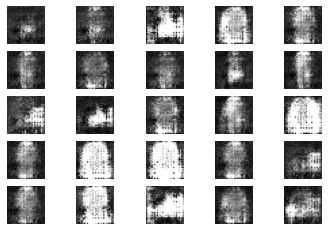

In [26]:
r, c = 5, 5
gen_imgs = gan.generate(r*c).cpu()
_, axs = plt.subplots(r, c)
for image, ax in zip(gen_imgs, axs.flat):
	image = image.mul(0.5).add(0.5)
	assert image.max() <= t.ones(1)
	ax.imshow(image.permute(1, 2, 0), cmap='gray')
	ax.axis('off')
plt.plot()

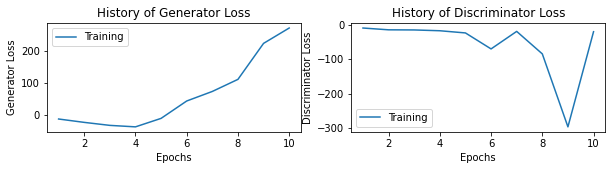

In [27]:
plot_metrics(list(history.keys()), history)